In [69]:
#We are going to create a Neural Network in order to predict a image classification of cats vs dogs


#PARAMETERS

##VARIABLES CHANGED
batch_size= 5
seedVal = 123;

#OPTIMIZERS
#opFunction = "Nesterov"
#opFunction="Adam"
opFunction="RMSprop"
NetStructure = "BN"
lr = 0.001
### PREAMBLE ################################################################
# allows the images to be displayed in the jupyter notebook
%matplotlib inline

# torch and torchvision related
import torch

dtype = torch.cuda.FloatTensor
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# image library
from PIL import Image

# some numeric stuff
import numpy as np
import random
import matplotlib.pyplot as plt

# file input/output libraries
import fnmatch
import os

# datetime
import datetime
now = datetime.datetime.now()

### OPTIONS #################################################################
# may want to later set from command line

# set random seed value

# at which epochs to record training/validation error
epochsConsidered = [1,3,4,5,6,7,9,12]
saveNetEpochsConsidered = True;

### PATHS ###################################################################

pathTrain = './data/FinalProjectTrainValTest/Train/'
pathVal = './data/FinalProjectTrainValTest/Val/'
pathOutput = './output/'
############################

In [70]:
# write what the transforms should be
# From website: Normalize an tensor image with mean and standard deviation. 
# Given mean: (M1,...,Mn)  and std: (S1,..,Sn) for n channels, this transform 
# will normalize each channel of the input
# for some reason resize has to come before ToTensor
transform = transforms.Compose( #lookup transforms.compose
    [transforms.Resize(size=32),
     transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



# load the train and val dataset
trainset = datasets.ImageFolder(root=pathTrain,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,shuffle=True, num_workers=2)

valset = datasets.ImageFolder(root=pathVal, transform=transform)
valloader = torch.utils.data.DataLoader(valset, shuffle=True, num_workers=2)

###classes must be in alphabetical order
classes = ('Cats', 'Dogs')
classes = sorted(classes) 
print(classes)

['Cats', 'Dogs']


 Dogs  Cats  Cats  Cats  Cats


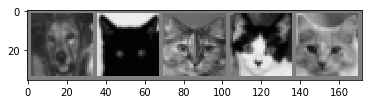

In [71]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #lookup np.transpose
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

##Update
#print(images)

#print(labels) #Dont need to see this for now

# show images
imshow(tv.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [72]:
#imshow(images[0])

In [73]:
classes = ['Cats','Dogs'];
for k in range(0,2): ### CAS: change to range(0,8)
    allTrainFiles = fnmatch.filter(os.listdir(pathTrain+classes[k]), '*.tif');
    allValFiles = fnmatch.filter(os.listdir(pathVal+classes[k]), '*.tif');

In [74]:
###DEFINING A CONVOLUTIONAL NEURAL NETWORK ARCHITECTURE #######################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #(input channels, output channels, size of the filter)
        self.pool = nn.MaxPool2d(2, 2) #size of the pool 2 by 2 matrix
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #(input sample, output sample)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80,2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.conv2_bn(x)
        x = x.view(-1, 16*5 * 5)
        x = F.relu(self.fc1(x)) #vector of size 1 by 120 
        x = F.relu(self.fc2(x)) #vector of size 1 by 84
        x = self.fc3(x)
        return x
    
net = Net()

In [75]:
### SET UP TO DETERMINE BEST NUMBER OF EPOCHS (HYPERPARAMETER)
# for each epoch considered, find the training and validation Accuracy
# initialize vectors here
trainAccuracy = [0]*len(epochsConsidered)
valAccuracy = [0]*len(epochsConsidered)
count = 0;

#IF statements for SGD Nesterov and Adam optimizer

if opFunction == "Nesterov":
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, nesterov=True)
if opFunction == "Adam":
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    
##ADDED A NEW OPTIMIZER##    
if opFunction == "RMSprop":
    optimizer = optim.RMSprop(net.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

In [76]:
# function to compute the percentage accuracy in categorizing images
def computeAccuracy(net, dataSubset):
    correct = 0
    total = 0
    # don't want batches, want to compute over the whole dataset
    dataSubsetLoader = torch.utils.data.DataLoader(dataSubset, num_workers=2)
    for data in dataSubsetLoader:
        images, labels = data  
        outputs = net(Variable(images))
        print(outputs)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum()

    percentAccuracy = 100 * correct / total
    print('Accuracy of the network is: %d %%' % (
        percentAccuracy))
    
    return(percentAccuracy)

In [77]:
### TRAIN NETWORK ######################################################

# set random seed
random.seed(seedVal);

criterion = nn.CrossEntropyLoss() 
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True)
##Added "nesterov = True" change maded on 3/25

### CAS: increased the number of epochs get better result
for epoch in range(np.max(epochsConsidered)):  # loop over the dataset multiple times  #We reduced the ranget (5)##

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        # print(loss.data)
        if i % 5 == 4:    # print every 5 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/5)) #try divide by 5
            running_loss = 0.0
            
    # For selected epochs, compute training and val (see note)
    # acccuracy, and save the network so that it can be reloaded
    if (epoch+1) in epochsConsidered:
        trainAccuracy[count] = computeAccuracy(net, trainset)
        valAccuracy[count] = computeAccuracy(net, valset)
        count = count + 1
        # save networks at the different epochs, to later load
        if (saveNetEpochsConsidered):
            saveFilename = str(now.strftime("%Y-%m-%d")) + opFunction+"-" + str(lr)+"-" + str(seedVal)+"-"+ NetStructure+"-"+ str(batch_size) + ('-Net%s_epochs.pth' % (epoch+1))
            savePath = os.path.join(pathOutput, 'networks', saveFilename)
            torch.save(net.cpu().state_dict(), savePath)
        
print('Finished Training')

[1,     5] loss: 0.711
[1,    10] loss: 0.679
[1,    15] loss: 0.795
[1,    20] loss: 0.640
[1,    25] loss: 0.672
Variable containing:
 0.9186 -0.5723
[torch.FloatTensor of size 1x2]

Variable containing:
 0.6215 -0.4638
[torch.FloatTensor of size 1x2]

Variable containing:
 0.3408 -0.0930
[torch.FloatTensor of size 1x2]

Variable containing:
 0.2285 -0.0723
[torch.FloatTensor of size 1x2]

Variable containing:
 0.9259 -0.6346
[torch.FloatTensor of size 1x2]

Variable containing:
 1.0305 -0.7602
[torch.FloatTensor of size 1x2]

Variable containing:
 0.6637 -0.4579
[torch.FloatTensor of size 1x2]

Variable containing:
 0.4747 -0.3005
[torch.FloatTensor of size 1x2]

Variable containing:
 1.1854 -0.8380
[torch.FloatTensor of size 1x2]

Variable containing:
 0.2071 -0.0961
[torch.FloatTensor of size 1x2]

Variable containing:
-0.2198  0.1449
[torch.FloatTensor of size 1x2]

Variable containing:
 1.1537 -0.8421
[torch.FloatTensor of size 1x2]

Variable containing:
 0.8081 -0.5689
[torch.F

Variable containing:
 0.9432 -0.7192
[torch.FloatTensor of size 1x2]

Variable containing:
 0.4142 -0.2632
[torch.FloatTensor of size 1x2]

Variable containing:
 0.8845 -0.6529
[torch.FloatTensor of size 1x2]

Variable containing:
 0.4491 -0.2668
[torch.FloatTensor of size 1x2]

Variable containing:
 0.5117 -0.3705
[torch.FloatTensor of size 1x2]

Variable containing:
 0.0986 -0.1134
[torch.FloatTensor of size 1x2]

Variable containing:
 0.9962 -0.7478
[torch.FloatTensor of size 1x2]

Variable containing:
 0.5035 -0.2056
[torch.FloatTensor of size 1x2]

Variable containing:
 0.4375 -0.3133
[torch.FloatTensor of size 1x2]

Variable containing:
1.00000e-02 *
  2.4549 -5.3919
[torch.FloatTensor of size 1x2]

Variable containing:
 0.3717 -0.2024
[torch.FloatTensor of size 1x2]

Variable containing:
 0.7108 -0.5429
[torch.FloatTensor of size 1x2]

Variable containing:
 0.2020 -0.0799
[torch.FloatTensor of size 1x2]

Variable containing:
1.00000e-02 *
  1.5562  2.7028
[torch.FloatTensor of s

Variable containing:
 2.2002 -1.3404
[torch.FloatTensor of size 1x2]

Variable containing:
 0.9633 -0.5476
[torch.FloatTensor of size 1x2]

Variable containing:
 2.3850 -1.3466
[torch.FloatTensor of size 1x2]

Variable containing:
 1.4032 -0.8728
[torch.FloatTensor of size 1x2]

Variable containing:
 1.6413 -0.9935
[torch.FloatTensor of size 1x2]

Variable containing:
 1.0886 -0.6566
[torch.FloatTensor of size 1x2]

Variable containing:
 2.3591 -1.3529
[torch.FloatTensor of size 1x2]

Variable containing:
 1.3424 -0.8421
[torch.FloatTensor of size 1x2]

Variable containing:
 0.8803 -0.5194
[torch.FloatTensor of size 1x2]

Variable containing:
 0.7205 -0.4532
[torch.FloatTensor of size 1x2]

Variable containing:
 1.2450 -0.7608
[torch.FloatTensor of size 1x2]

Variable containing:
 1.3618 -0.8398
[torch.FloatTensor of size 1x2]

Variable containing:
 1.1213 -0.6338
[torch.FloatTensor of size 1x2]

Variable containing:
-0.4758  0.4016
[torch.FloatTensor of size 1x2]

Variable containing:

Variable containing:
 2.5164 -1.5837
[torch.FloatTensor of size 1x2]

Variable containing:
 0.7102 -0.4270
[torch.FloatTensor of size 1x2]

Variable containing:
 3.1565 -1.7872
[torch.FloatTensor of size 1x2]

Variable containing:
 0.8138 -0.5876
[torch.FloatTensor of size 1x2]

Variable containing:
 1.9672 -1.1905
[torch.FloatTensor of size 1x2]

Variable containing:
 1.3137 -0.8951
[torch.FloatTensor of size 1x2]

Variable containing:
 3.0198 -1.7327
[torch.FloatTensor of size 1x2]

Variable containing:
-0.4080  0.3705
[torch.FloatTensor of size 1x2]

Variable containing:
 1.1604 -0.7109
[torch.FloatTensor of size 1x2]

Variable containing:
 0.8950 -0.7059
[torch.FloatTensor of size 1x2]

Variable containing:
 0.9217 -0.6055
[torch.FloatTensor of size 1x2]

Variable containing:
 2.0125 -1.2490
[torch.FloatTensor of size 1x2]

Variable containing:
1.00000e-02 *
  5.8358  4.5235
[torch.FloatTensor of size 1x2]

Variable containing:
-2.2052  1.8805
[torch.FloatTensor of size 1x2]

Varia

Variable containing:
 2.7235 -1.7320
[torch.FloatTensor of size 1x2]

Variable containing:
 1.1983 -0.7146
[torch.FloatTensor of size 1x2]

Variable containing:
 3.3083 -1.8808
[torch.FloatTensor of size 1x2]

Variable containing:
 1.2328 -0.8250
[torch.FloatTensor of size 1x2]

Variable containing:
 2.3329 -1.4196
[torch.FloatTensor of size 1x2]

Variable containing:
 0.9127 -0.7544
[torch.FloatTensor of size 1x2]

Variable containing:
 2.9759 -1.7201
[torch.FloatTensor of size 1x2]

Variable containing:
 1.3384 -0.8873
[torch.FloatTensor of size 1x2]

Variable containing:
 1.2078 -0.7534
[torch.FloatTensor of size 1x2]

Variable containing:
 0.1445 -0.2062
[torch.FloatTensor of size 1x2]

Variable containing:
 1.5461 -0.9692
[torch.FloatTensor of size 1x2]

Variable containing:
 1.7876 -1.1794
[torch.FloatTensor of size 1x2]

Variable containing:
 1.6217 -0.9191
[torch.FloatTensor of size 1x2]

Variable containing:
-1.6643  1.4218
[torch.FloatTensor of size 1x2]

Variable containing:

Variable containing:
 4.1914 -2.5642
[torch.FloatTensor of size 1x2]

Variable containing:
 1.6743 -0.9800
[torch.FloatTensor of size 1x2]

Variable containing:
 4.7786 -2.8277
[torch.FloatTensor of size 1x2]

Variable containing:
 1.1976 -0.8100
[torch.FloatTensor of size 1x2]

Variable containing:
 2.9467 -1.8288
[torch.FloatTensor of size 1x2]

Variable containing:
 2.5372 -1.6575
[torch.FloatTensor of size 1x2]

Variable containing:
 4.8365 -2.8330
[torch.FloatTensor of size 1x2]

Variable containing:
 1.1115 -0.6587
[torch.FloatTensor of size 1x2]

Variable containing:
 2.0163 -1.2156
[torch.FloatTensor of size 1x2]

Variable containing:
 1.9142 -1.3695
[torch.FloatTensor of size 1x2]

Variable containing:
 1.6493 -1.0545
[torch.FloatTensor of size 1x2]

Variable containing:
 3.2369 -1.9959
[torch.FloatTensor of size 1x2]

Variable containing:
 2.0031 -1.1485
[torch.FloatTensor of size 1x2]

Variable containing:
-1.8642  1.5315
[torch.FloatTensor of size 1x2]

Variable containing:

Variable containing:
 2.9583 -1.8348
[torch.FloatTensor of size 1x2]

Variable containing:
 1.4078 -0.8615
[torch.FloatTensor of size 1x2]

Variable containing:
 3.7273 -2.1255
[torch.FloatTensor of size 1x2]

Variable containing:
 0.9020 -0.6110
[torch.FloatTensor of size 1x2]

Variable containing:
 2.7984 -1.7304
[torch.FloatTensor of size 1x2]

Variable containing:
 2.3016 -1.3289
[torch.FloatTensor of size 1x2]

Variable containing:
 3.4562 -1.9565
[torch.FloatTensor of size 1x2]

Variable containing:
 0.8030 -0.4685
[torch.FloatTensor of size 1x2]

Variable containing:
 1.3927 -0.8292
[torch.FloatTensor of size 1x2]

Variable containing:
 1.7296 -1.0216
[torch.FloatTensor of size 1x2]

Variable containing:
 1.8692 -1.1476
[torch.FloatTensor of size 1x2]

Variable containing:
 2.3170 -1.3619
[torch.FloatTensor of size 1x2]

Variable containing:
 2.1870 -1.2277
[torch.FloatTensor of size 1x2]

Variable containing:
-2.4014  2.0338
[torch.FloatTensor of size 1x2]

Variable containing:

Variable containing:
 5.0114 -3.0947
[torch.FloatTensor of size 1x2]

Variable containing:
 2.3705 -1.4602
[torch.FloatTensor of size 1x2]

Variable containing:
 4.8614 -2.8688
[torch.FloatTensor of size 1x2]

Variable containing:
 1.8790 -1.1733
[torch.FloatTensor of size 1x2]

Variable containing:
 3.9463 -2.4560
[torch.FloatTensor of size 1x2]

Variable containing:
 1.9004 -1.1684
[torch.FloatTensor of size 1x2]

Variable containing:
 4.5267 -2.6617
[torch.FloatTensor of size 1x2]

Variable containing:
 2.2746 -1.2504
[torch.FloatTensor of size 1x2]

Variable containing:
 1.9619 -1.1658
[torch.FloatTensor of size 1x2]

Variable containing:
 1.1486 -0.7448
[torch.FloatTensor of size 1x2]

Variable containing:
 2.9607 -1.8173
[torch.FloatTensor of size 1x2]

Variable containing:
 3.2227 -1.9124
[torch.FloatTensor of size 1x2]

Variable containing:
 3.3152 -1.9128
[torch.FloatTensor of size 1x2]

Variable containing:
-4.0195  3.7731
[torch.FloatTensor of size 1x2]

Variable containing:

Variable containing:
 6.7817 -4.3276
[torch.FloatTensor of size 1x2]

Variable containing:
 2.5522 -1.6296
[torch.FloatTensor of size 1x2]

Variable containing:
 6.3963 -4.0758
[torch.FloatTensor of size 1x2]

Variable containing:
 1.1193 -0.6316
[torch.FloatTensor of size 1x2]

Variable containing:
 4.1630 -2.7097
[torch.FloatTensor of size 1x2]

Variable containing:
 4.2025 -2.7091
[torch.FloatTensor of size 1x2]

Variable containing:
 6.6248 -4.1700
[torch.FloatTensor of size 1x2]

Variable containing:
 1.3441 -0.6006
[torch.FloatTensor of size 1x2]

Variable containing:
 3.0403 -1.9148
[torch.FloatTensor of size 1x2]

Variable containing:
 2.9424 -1.9407
[torch.FloatTensor of size 1x2]

Variable containing:
 2.6839 -1.7269
[torch.FloatTensor of size 1x2]

Variable containing:
 4.7482 -3.0425
[torch.FloatTensor of size 1x2]

Variable containing:
 3.4765 -2.1115
[torch.FloatTensor of size 1x2]

Variable containing:
-4.3583  4.1152
[torch.FloatTensor of size 1x2]

Variable containing:

In [78]:
#Now we define a couple functions that will allow us to visualize the network. 
# The first gets the activations at a given layer for a given input image. 
#The second plots those activations in a grid.
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)

In [79]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(tmp.shape[3] / n_columns)
    for i in range(0, filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

In [80]:
#Now we can choose an image to pass through the 
#network to visualize the network activation, 
#and look at the raw pixels of that image.

# dataiterval = iter(valloader)
# imagesVal, labelsVal = dataiter.next()
# ImageToUse = imagesVal[0]
# imshow(imageToUse)

In [81]:
# dataiterval = iter(valloader)
# imagesval, labelsval = dataiter.next()

# # print images
# imshow(tv.utils.make_grid(images))

# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [82]:
np.max(valAccuracy)

93.333333333333329

In [83]:
epochsConsidered[np.argmax(valAccuracy)]

6

In [84]:
trainAccuracy

[79.23076923076923,
 90.76923076923077,
 90.0,
 87.6923076923077,
 93.84615384615384,
 96.92307692307692,
 96.15384615384616,
 99.23076923076923]

In [85]:
trainAccuracy[np.argmax(valAccuracy)]

93.84615384615384

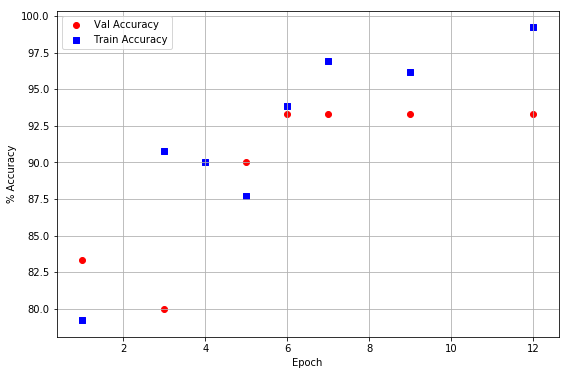

In [86]:
### FIGURE TO SHOW TRAIN AND VAL ERROR ############################

# initialize figure
plt.figure(figsize=(9, 6)) 

# the two scatter grap data sets
data1 = plt.scatter(epochsConsidered, valAccuracy, color='r', marker='o', label='Val Accuracy')
data2 = plt.scatter(epochsConsidered, trainAccuracy, color='b', marker='s', label='Train Accuracy')

# formatting
plt.xlabel('Epoch')
plt.ylabel('% Accuracy')
plt.legend()
plt.grid()

# save to file
fig = plt.gcf()
fig.savefig(pathOutput + str(now.strftime("%Y-%m-%d")) + opFunction+"-" + str(lr)+"-" + str(seedVal)+"-"+ NetStructure+"-"+ str(batch_size)+
            '.png', bbox_inches="tight")

In [87]:
fileToLoad = '2018-05-05RMSprop-0.001-123-BN-5-Net6_epochs.pth'

In [88]:
computeAccuracy(net, valset)

Variable containing:
 6.7817 -4.3276
[torch.FloatTensor of size 1x2]

Variable containing:
 2.5522 -1.6296
[torch.FloatTensor of size 1x2]

Variable containing:
 6.3963 -4.0758
[torch.FloatTensor of size 1x2]

Variable containing:
 1.1193 -0.6316
[torch.FloatTensor of size 1x2]

Variable containing:
 4.1630 -2.7097
[torch.FloatTensor of size 1x2]

Variable containing:
 4.2025 -2.7091
[torch.FloatTensor of size 1x2]

Variable containing:
 6.6248 -4.1700
[torch.FloatTensor of size 1x2]

Variable containing:
 1.3441 -0.6006
[torch.FloatTensor of size 1x2]

Variable containing:
 3.0403 -1.9148
[torch.FloatTensor of size 1x2]

Variable containing:
 2.9424 -1.9407
[torch.FloatTensor of size 1x2]

Variable containing:
 2.6839 -1.7269
[torch.FloatTensor of size 1x2]

Variable containing:
 4.7482 -3.0425
[torch.FloatTensor of size 1x2]

Variable containing:
 3.4765 -2.1115
[torch.FloatTensor of size 1x2]

Variable containing:
-4.3583  4.1152
[torch.FloatTensor of size 1x2]

Variable containing:

93.33333333333333

In [89]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

for data in valloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs, 1)
    c = (predicted == Variable(labels)).squeeze().type(torch.LongTensor)
    label = np.int(labels)
    class_correct[label] += c
    class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
    classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of  Cats : 93 %
Accuracy of  Dogs : 93 %
